In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from base import PromptAttn, p_svm_solver

In [2]:
g_converge = True
T = 3
d = 3
ITN = 1000
init_p = torch.tensor([
    [0.,1.,0],
    [0.,0.5,0],
    [0.,0.,0],
    [0.,-0.5,0],
    [0.,-1.,0],
    [0.,-1.5,0],
])

ps = np.zeros((init_p.shape[0], ITN, d))

def data_generator():
    v = torch.tensor([0,0,1])
    Y = torch.tensor([1])
    if g_converge:
        X = torch.tensor([[[-0.1,1,1],[1,0,0.9],[0,0,0.9]]])
    else:
        X = torch.tensor([[[-0.1,1,1],[1,0,0.9],[0,0,0]]])
    return X, Y, v

In [3]:
for i in range(init_p.shape[0]):
    X, Y, v = data_generator()
    model = PromptAttn(d, identity_W=False)
    model.key.weight.data   = torch.tensor([[1.,0,0],[0,1.,0],[0,0,0]])
    model.query.weight.data = torch.tensor([[1.,0,0],[0,1.,0],[0,0,0]])
    model.prompt.data = init_p[i].clone().float().view(-1)
    model.w.data = torch.tensor(np.array(v)).float().view(-1)
    optimizer = torch.optim.SGD([model.prompt], lr=0.1)
    for it in range(ITN):
        ps[i,it] = model.prompt.detach().numpy()
        optimizer.zero_grad()    
        loss = torch.log(1+torch.exp(-Y*model(X)))
        loss = loss.mean()
        loss.backward()
        model.prompt.grad /= (model.prompt.grad.norm()+0.000000001)
        optimizer.step()

     pcost       dcost       gap    pres   dres
 0:  1.9157e-01  3.8314e-01  6e-01  1e+00  2e-16
 1:  3.1526e-01  4.4010e-01  5e-02  2e-01  1e-16
 2:  5.0096e-01  4.9031e-01  1e-02  8e-17  9e-16
 3:  4.9511e-01  4.9459e-01  5e-04  2e-16  1e-16
 4:  4.9505e-01  4.9504e-01  6e-06  8e-17  5e-16
 5:  4.9505e-01  4.9505e-01  6e-08  2e-16  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.9194e-01  3.8580e-01  6e-01  1e+00  2e-16
 1:  3.1693e-01  4.4402e-01  5e-02  2e-01  0e+00
 2:  5.0601e-01  4.9521e-01  1e-02  1e-16  1e-15
 3:  5.0006e-01  4.9954e-01  5e-04  2e-17  4e-16
 4:  5.0000e-01  4.9999e-01  7e-06  2e-16  7e-16
 5:  5.0000e-01  5.0000e-01  7e-08  1e-17  2e-16
Optimal solution found.


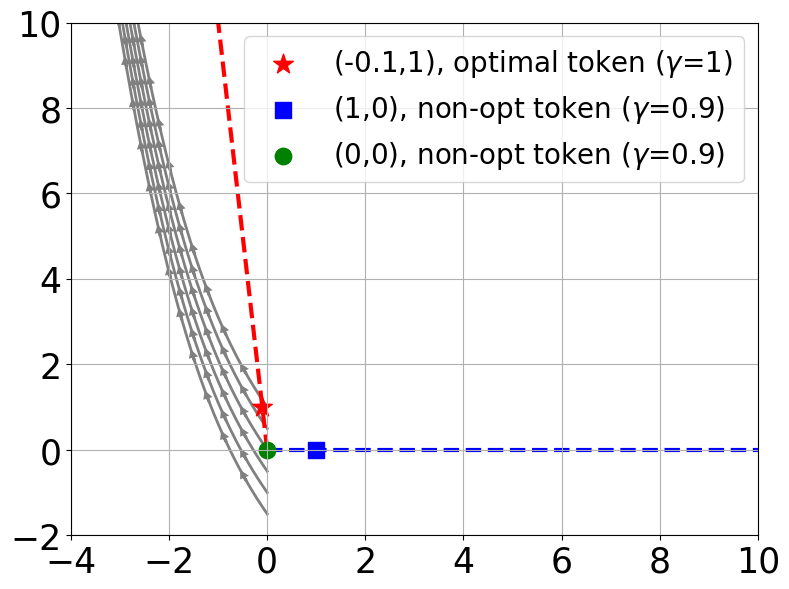

In [4]:
W = model.key.weight.data.T @ model.query.weight.data
sol_global, _ = p_svm_solver(X, W, torch.tensor([0]))
sol_local, _ = p_svm_solver(X, W, torch.tensor([1]))


plt.figure(figsize=(8,6))
labels = [
    r'(-0.1,1), optimal token ($\gamma$=1)', 
    r'(1,0), non-opt token ($\gamma$=0.9)', 
    rf'(0,0), non-opt token ($\gamma$={0.9 if g_converge else 0})'
]
plt.scatter(X[0,0,0],X[0,0,1], marker='*',color='r',s=220, label=labels[0], zorder=1)
plt.scatter(X[0,1,0],X[0,1,1],marker='s',color='b',s=140, label=labels[1], zorder=1)
plt.scatter(X[0,2,0],X[0,2,1],color='g',s=140, label=labels[2], zorder=1)

x = np.arange(0,20)
plt.plot(-x,sol_global[1]/sol_global[0]*-x, 'r--', linewidth=3, zorder=0)
plt.plot(x,sol_local[1]/sol_local[0]*x,'b--', linewidth=3, zorder=0)

THRED = 200
for i in range(init_p.shape[0]):
    plt.plot(ps[i,:THRED,0], ps[i,:THRED,1], linewidth=2, linestyle='-', color='gray', zorder=-1)
    for j in range(THRED):
        if (j+1) % 10 == 0:
            plt.arrow((ps[i,j,0]), (ps[i,j,1]), (ps[i,j+1,0]-ps[i,j,0]), (ps[i,j+1,1]-ps[i,j,1]), length_includes_head=False,head_width=0.1, head_length=0.1, color='gray', linewidth=2, zorder=-1)


if not g_converge:
    plt.xlim([-2,12])
    plt.ylim([-2,10])
else:
    plt.xlim([-4,10])
    plt.ylim([-2,10])

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20, loc='upper right')
plt.grid()
plt.tight_layout()
plt.show()